# Table of contents
- [What is `mercury-graph`?](#mercury-graph)
- [Environment setup](#environment-setup)
- [Graph creation](#graph-creation)
- [Accessing graph properties](#graph-properties)
- [Graph embeddings](#graph-embeddings)
- [Node2Vec with Spark](#node2vec)
- [Louvain community detection with Spark](#louvain)
- [Spectral clustering](#spectral)
- [Transition matrix (Markov chains)](#transition)
- [Spread activation with Spark](#spread-activation)

# What is `mercury-graph`? <a name="mercury-graph"></a>

**`mercury-graph`** is a Python library that offers **graph analytics capabilities with a technology-agnostic API**, enabling users to apply a curated range of performant and scalable algorithms and utilities regardless of the underlying data framework. The consistent, scikit-like interface abstracts away the complexities of internal transformations, allowing users to effortlessly switch between different graph representations to leverage optimized algorithms implemented using pure Python, [**numba**](https://numba.pydata.org/), [**networkx**](https://networkx.org/) and PySpark [**GraphFrames**](https://graphframes.github.io/graphframes/docs/_site/index.html).

It is a part of [**`mercury`**](https://www.bbvaaifactory.com/mercury/), a collaborative library developed by the **Advanced Analytics community at BBVA** that offers a broad range of tools to simplify and accelerate data science workflows. This library was originally an Inner Source project, but some components, like `mercury.graph`, have been released as Open Source.

Currently implemented **submodules** in `mercury.graph` include:
- [**`mercury.graph.core`**](#graph-creation), with the main classes of the library that create and store the graphs' data and properties.
- **`mercury.graph.ml`**, with graph theory and machine learning algorithms such as [Louvain community detection](#louvain), [spectral clustering](#spectral), [Markov chains](#transition), [spreading activation-based diffusion models](#spread-activation) and graph random walkers.
- **`mercury.graph.embeddings`**, with classes that calculate [graph embeddings](#graph-embeddings) in different ways, such as following the [Node2Vec](#node2vec) algorithm.


# Environment setup <a name="environment-setup"></a>



<div class="alert alert-block alert-info">
<b>Note:</b> This notebook requires Spark and Graphframes, which are installed below.
</div>

In [ ]:
# Mercury-Graph
! pip install mercury-graph

# PySpark - Latest version: 3.5.3, including Spark, already installed in Google Colab
# ! pip install pyspark

# GraphFrames - Latest version: 0.8.3
! pip install graphframes-latest

# PyVis - Interactive graph visualization
! pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mercury-graph: filename=mercury_graph-3.2.1-py3-none-any.whl size=466703 sha256=cd01e191b2d4d3ee906b2ee6c4543fe6bc75e0b970cad761c644cec4ecb6c89a
  Stored in directory: /root/.cache/pip/wheels/5a/95/5a/875286fc4b346d364b10ad8d61ebc99c0a2e15d321e4a59383
Successfully built mercury-graph
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for graphframes-latest: filename=graphframes_latest-0.8.3-py3-none-any.whl size=21228 sha256=3e5db7afc0ba8ab056314e23b219909c19f44b6028ebcfa1961e6d13915c98ac
  Stored in directory: /root/.cache/pip/wheels/9d/2d/15/2c073852bec997aafdd4c5625db7e522573a333c7123144b61
Successfully built graphframes-latest
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From `mercury.graph`, we first **import**:

- **`Graph`**, to create graphs **from pandas/Spark dataframes or from [networkx](https://networkx.org/)/[graphframes](https://graphframes.github.io/graphframes/docs/_site/index.html) graph objects**. It is the core class of the library, storing the graphs' data and properties and offering a **flexible and technology-agnostic API**.
- **`SparkInterface`**, to initialize a new Spark session or get an existing one.

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pyspark")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from mercury.graph.core import Graph, SparkInterface

import pyspark.sql.functions as f

When creating the Spark session, we must specify the graphframes jar package to be installed, loaded and used (the library installed above provides the Python API).

In [ ]:
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.3-spark3.5-s_2.12 pyspark-shell"
spark = SparkInterface().spark

It may also be useful to display the Spark UI in order to track resource usage within Spark.

In [ ]:
# View Spark UI in Google Colab
from google.colab import output
output.serve_kernel_port_as_iframe(4040, path='/jobs/index.html')

# Deprecated due to browser security updates, but still works and enables opening Spark UI in a new tab:
# output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

# Graph creation <a name="graph-creation"></a>

We will create a graph `g` based on the [**FIFA 2017 dataset**](https://www.kaggle.com/datasets/artimous/complete-fifa-2017-player-dataset-global):
- From the original dataset, since players lack a proper ID, duplicated names were removed.
- Edges are created by random sampling the interactions between any two players.
- Players who share the same club or the same position count 1, if both then 2 (column `times`, which will represent the weights of the edges of the graph).

In [ ]:
df_edges = pd.read_csv("https://raw.githubusercontent.com/BBVA/mercury-graph/refs/heads/master/tutorials/data/fifa17_edges.csv", sep="\t")

df_edges[(df_edges["ori"]=="Gianluigi Buffon") |
         (df_edges["dest"]=="Gianluigi Buffon")].head()

,ori,dest,times
18021,Paolo De Ceglie,Gianluigi Buffon,1
19662,Jan Oblak,Gianluigi Buffon,1
21798,Faisal Al Masrahi,Gianluigi Buffon,1
21941,Gianluigi Buffon,Rolando Mandragora,1
61777,Alex Cisak,Gianluigi Buffon,1


From the original node (player) attributes, just the club and the position are kept.

In [ ]:
df_nodes = pd.read_csv("https://raw.githubusercontent.com/BBVA/mercury-graph/refs/heads/master/tutorials/data/fifa17_nodes.csv", sep="\t")

df_nodes[df_nodes["name"]=="Gianluigi Buffon"]

,name,club,position
31,Gianluigi Buffon,Juventus,GK


In [ ]:
g = Graph(data=df_edges,
          nodes=df_nodes,
          keys={"src": "ori",
                "dst": "dest",
                "weight": "times",
                "id": "name"})

print(g)

mercury.graph.core.Graph with 17119 nodes and 89986 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: False
  has_dgl:        False


Given that `Graph` has been provided pandas dataframes as inputs, a [networkx](https://networkx.org/) object has been created internally (`has_networkx: True`). If Spark dataframes are provided, a [graphframes](https://graphframes.github.io/graphframes/docs/_site/index.html) object is created internally (`has_graphframe: True`):

In [ ]:
g2 = Graph(data=spark.createDataFrame(df_edges),
           nodes=spark.createDataFrame(df_nodes),
           keys={"src": "ori",
                 "dst": "dest",
                 "weight": "times",
                 "id": "name"})

print(g2)

mercury.graph.core.Graph with 17119 nodes and 89986 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   False
  has_graphframe: True
  has_dgl:        False


To execute some algorithms faster and better visualize the results, two **subgraphs** will be created:
- `g_italy`, containing all players that are part of **Italian clubs**.
- `g_roma_11`, containing only the subset of **players from AS Roma's starting eleven** as nodes.
Subgraphs can be built filtering node attributes using networkx methods.

In [ ]:
italy_clubs = ["Atalanta", "Bologna", "Cagliari", "Chievo Verona", "Crotone", "Empoli", "Fiorentina", "Genoa", "Inter", "Juventus", "Lazio", "Milan", "Napoli", "Palermo", "Pescara", "Roma", "Sampdoria", "Sassuolo", "Torino", "Udinese"]
italy_players = [node for node, attrs in g.networkx.nodes(data=True)
                 if attrs["club"] in italy_clubs]

g_italy = Graph(g.networkx.subgraph(italy_players))
print(g_italy)

mercury.graph.core.Graph with 534 nodes and 1432 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: False
  has_dgl:        False


In [ ]:
starting_roma_players = [node for node, attrs in g.networkx.nodes(data=True)
                         if attrs["club"]=="Roma"
                         and not attrs["position"] in ["Res", "Sub"]]

g_roma_11 = Graph(g.networkx.subgraph(starting_roma_players))
print(g_roma_11)

mercury.graph.core.Graph with 11 nodes and 15 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: False
  has_dgl:        False


Next, some functions and utilities are defined for plotting graphs and results.

In [ ]:
def plot_football_field(g, player_positions, node_colors):
  plt.figure(figsize=(10, 8))
  plt.gca().set_facecolor(color_palette["whiteblue"])
  nx.draw_networkx(g.networkx,
                   pos=player_positions,
                   node_color=node_colors,
                   font_size=6,
                   font_weight="bold",
                   font_color="black",
                   edge_color=color_palette["darkblue"])

color_palette = {
    'navy': '#072146',
    'darkblue': '#004481',
    'darkaqua': '#028484',
    'blue': '#1973b8',
    'aqua': '#2dcccd',
    'lightblue': '#49a5e6',
    'whiteblue': '#d4edfc',
}

default_node_colors = lambda node_data: [color_palette["aqua"] if attr["position"]=="GK" else
                                         color_palette["darkaqua"] if attr["position"] in ["LB", "RB", "LCB", "CB", "RCB"] else
                                         color_palette["blue"] if attr["position"] in ["RM", "LM", "RDM", "LDM", "RCM", "LCM", "CAM"] else
                                         color_palette["lightblue"] for n, attr in node_data]

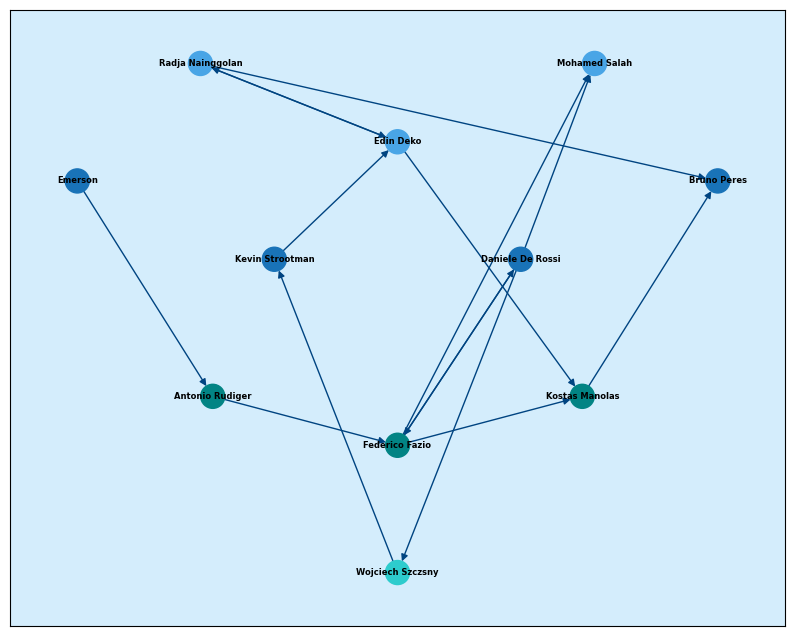

In [ ]:
player_positions_roma = {
    "Wojciech Szczsny": (0.5, 0.5),
    "Antonio Rudiger": (-0.25, 1.4),
    "Federico Fazio": (0.5, 1.15),
    "Kostas Manolas": (1.25, 1.4),
    "Emerson": (-0.8, 2.5),
    "Kevin Strootman": (0, 2.10),
    "Daniele De Rossi": (1, 2.10),
    "Bruno Peres": (1.8, 2.5),
    "Radja Nainggolan": (-0.3, 3.1),
    "Edin Deko": (0.5, 2.7),
    "Mohamed Salah": (1.3, 3.1),
}

plot_football_field(g_roma_11,
                    player_positions=player_positions_roma,
                    node_colors=default_node_colors(g_roma_11.networkx.nodes(data=True)))

# Accessing graph properties <a name="graph-properties"></a>

Given that `Graph` has been provided pandas dataframes as inputs to create object `g`, a networkx object has been created internally (`has_networkx: True`). However, at any point, the networkx or graphframes representation of the `Graph` object can be accessed through properties `g.networkx` and `g.graphframe`, respectively. The objects are created when accessing these properties for the first time and are stored for later use. All classes and methods in `mercury.graph` that expect a `Graph` object as input internally perform the required conversions (if necessary) according to each algorithm's implementation.

For example, we can access the **networkx representation** of the created graph to use networkx's methods and API:

In [ ]:
print(f"Club: {g.networkx.nodes(data='club')['Gianluigi Buffon']}")
print(f"Position: {g.networkx.nodes(data='position')['Gianluigi Buffon']}")

Club: Juventus
Position: GK


We can also access the **graphframes representation**, which will first generate the graphframes object:

In [ ]:
g.graphframe.outDegrees.filter(f.col("id")=='Gianluigi Buffon').show()

+----------------+---------+
|              id|outDegree|
+----------------+---------+
|Gianluigi Buffon|        2|
+----------------+---------+



Note that further accesses to the graphframe property will use the cached object (`has_graphframe: True`, as well as `has_networkx: True` already available since the object construction from pandas dataframes).

In [ ]:
print(g)

mercury.graph.core.Graph with 17119 nodes and 89986 edges.
  is_directed:    True
  is_weighted:    True
  has_networkx:   True
  has_graphframe: True
  has_dgl:        False


Several other **properties** can be accessed from the `Graph` object, **regardless of the underlying technology**:
- PageRank algorithm
- Degree, indegree, outdegree of the nodes
- Connected components
- Betweenness centrality, closeness centrality

The **PageRank algorithm** (see paper [here](https://www.semanticscholar.org/paper/The-PageRank-Citation-Ranking-%3A-Bringing-Order-to-Page-Brin/eb82d3035849cd23578096462ba419b53198a556)) assigns a numerical score to each node in the graph, representing its relative importance within the graph. A higher score means the node is more important or influential (these nodes are typically well-connected and linked to other high-scoring nodes). In this implementation, scores are normalized to sum up to 1.

In [ ]:
pagerank_result = g_roma_11.pagerank

print(f"Total sum: {sum(pagerank_result.values())}\n")

# Get top 10 results from the pagerank dictionary
dict(sorted(pagerank_result.items(), key=lambda item: item[1], reverse=True)[:10])

Total sum: 1.0000000000000002



{'Bruno Peres': 0.1761521232848639,
 'Edin Deko': 0.13824815864661164,
 'Kostas Manolas': 0.12171193359053867,
 'Federico Fazio': 0.10399335362077541,
 'Radja Nainggolan': 0.09224706476464416,
 'Mohamed Salah': 0.0807936362495565,
 'Kevin Strootman': 0.07711980912883011,
 'Daniele De Rossi': 0.06295598726298207,
 'Antonio Rudiger': 0.061958047590448026,
 'Wojciech Szczsny': 0.05132876742366198}

In [ ]:
name = "Daniele De Rossi"
print(f"Degree: {g_roma_11.degree[name]}")
print(f"Indegree: {g_roma_11.in_degree[name]}")
print(f"Outdegree: {g_roma_11.out_degree[name]}")
print(f"Connected components: {g_roma_11.connected_components[name]}")
print(f"Betweenness centrality: {g_roma_11.betweenness_centrality[name]}")
print(f"Closeness centrality: {g_roma_11.closeness_centrality[name]}")

Degree: 4
Indegree: 1
Outdegree: 3
Connected components: {'cc_id': 0, 'cc_size': 11}
Betweenness centrality: 0.13333333333333333
Closeness centrality: 0.15


In [ ]:
print(f"Number of connected components: {len(set([v['cc_id'] for k, v in g_roma_11.connected_components.items()]))}\n")

list(g_roma_11.connected_components.items())

Number of connected components: 1



[('Antonio Rudiger', {'cc_id': 0, 'cc_size': 11}),
 ('Emerson', {'cc_id': 0, 'cc_size': 11}),
 ('Kevin Strootman', {'cc_id': 0, 'cc_size': 11}),
 ('Wojciech Szczsny', {'cc_id': 0, 'cc_size': 11}),
 ('Radja Nainggolan', {'cc_id': 0, 'cc_size': 11}),
 ('Daniele De Rossi', {'cc_id': 0, 'cc_size': 11}),
 ('Mohamed Salah', {'cc_id': 0, 'cc_size': 11}),
 ('Kostas Manolas', {'cc_id': 0, 'cc_size': 11}),
 ('Bruno Peres', {'cc_id': 0, 'cc_size': 11}),
 ('Federico Fazio', {'cc_id': 0, 'cc_size': 11}),
 ('Edin Deko', {'cc_id': 0, 'cc_size': 11})]

As could be seen in the plot, all nodes of the AS Roma subgraph are connected and thus there is only one connected component. If we create another subgraph with the interactions between the players of the starting eleven of Juventus FC, three connected components can be observed and are indeed detected.

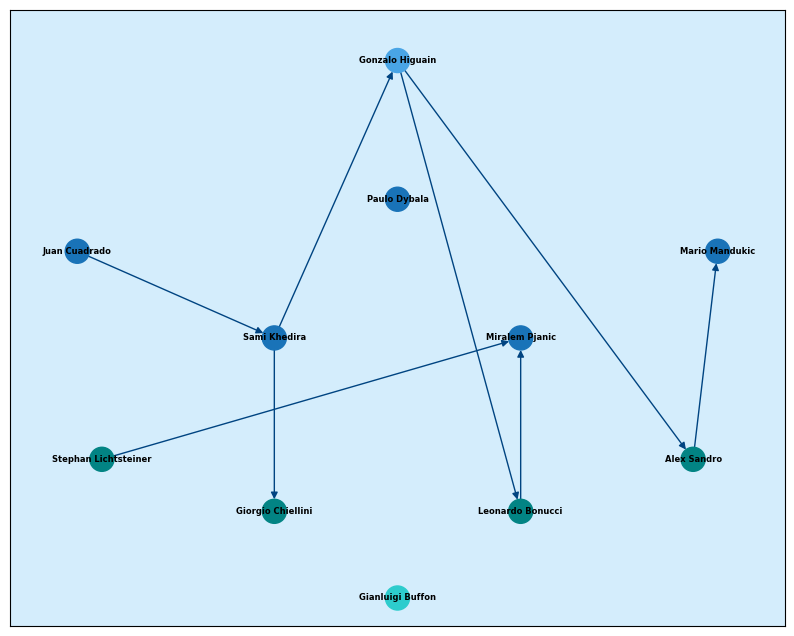

In [ ]:
starting_juve_players = [node for node, attrs in g.networkx.nodes(data=True)
                         if attrs["club"]=="Juventus"
                         and not attrs["position"] in ["Res", "Sub"]]
g_juve_11 = Graph(g.networkx.subgraph(starting_juve_players))

player_positions_juve = {
      "Gianluigi Buffon": (0.5, 0.5),
      "Stephan Lichtsteiner": (-0.7, 1.3),
      "Leonardo Bonucci": (1, 1),
      "Giorgio Chiellini": (0, 1),
      "Alex Sandro": (1.7, 1.3),
      "Juan Cuadrado": (-0.8, 2.5),
      "Sami Khedira": (0, 2),
      "Miralem Pjanic": (1, 2),
      "Mario Mandukic": (1.8, 2.5),
      "Paulo Dybala": (0.5, 2.8),
      "Gonzalo Higuain": (0.5, 3.6)
  }

plot_football_field(g_juve_11, player_positions=player_positions_juve, node_colors=default_node_colors(g_juve_11.networkx.nodes(data=True)))

In [ ]:
print(f"Number of connected components: {len(set([v['cc_id'] for k, v in g_juve_11.connected_components.items()]))}\n")

list(g_juve_11.connected_components.items())

Number of connected components: 3



[('Miralem Pjanic', {'cc_id': 0, 'cc_size': 9}),
 ('Gonzalo Higuain', {'cc_id': 0, 'cc_size': 9}),
 ('Sami Khedira', {'cc_id': 0, 'cc_size': 9}),
 ('Alex Sandro', {'cc_id': 0, 'cc_size': 9}),
 ('Giorgio Chiellini', {'cc_id': 0, 'cc_size': 9}),
 ('Juan Cuadrado', {'cc_id': 0, 'cc_size': 9}),
 ('Leonardo Bonucci', {'cc_id': 0, 'cc_size': 9}),
 ('Stephan Lichtsteiner', {'cc_id': 0, 'cc_size': 9}),
 ('Mario Mandukic', {'cc_id': 0, 'cc_size': 9}),
 ('Gianluigi Buffon', {'cc_id': 1, 'cc_size': 1}),
 ('Paulo Dybala', {'cc_id': 2, 'cc_size': 1})]

# Graph embeddings <a name="graph-embeddings"></a>

Class `GraphEmbeddings` of mercury.graph.embeddings creates an **embedding mapping the nodes of a graph by doing random walks**, implemented using numpy and networkx. These walks start from a random node and select the edges with a probability that is proportional to the **weight** of the edge.

In [ ]:
from mercury.graph.embeddings import GraphEmbedding

In [ ]:
ge = GraphEmbedding(dimension=140,
                    n_jumps=100000,
                    max_per_epoch=1000,
                    learn_step=1,
                    bidirectional=True)

print(ge)

Object of class GraphEmbedding.

Initialization parameters: bidirectional=True, dimension=140, learn_step=1, load_file=None, max_per_epoch=1000, n_jumps=100000


In [ ]:
ge.fit(g_italy)

GraphEmbedding(bidirectional=True, dimension=140, learn_step=1, load_file=None, max_per_epoch=1000, n_jumps=100000)

After fitting the object to the subgraph, an `Embedding` object is created, containing the representation of the vector embeddings matrix.

In [ ]:
print(ge.embedding(), "\n")

ge_em_np = ge.embedding().as_numpy()
print(f"Shape: {ge_em_np.shape} \n")
print(ge_em_np)

Object of class Embeddings.

Initialization parameters: bidirectional=True, dimension=140, learn_step=1, mean=0, num_elements=534, sd=1 

Shape: (534, 140) 

[[-0.0470889  -1.07566642 -0.4313176  ... -0.2522281   2.0511268
   0.65430769]
 [ 0.38573419 -0.91375569  1.12423956 ...  1.30839612  1.024746
  -0.96500611]
 [-0.45376925  0.67170724  0.52980228 ...  2.10119764 -0.22508847
  -0.07639249]
 ...
 [-0.98882259 -0.03284027 -0.89162811 ...  1.03569726 -0.982516
   0.34917702]
 [ 1.87194138 -0.42422507  0.32432609 ... -0.18389209  1.29912599
  -0.18366174]
 [ 0.63322819  0.77633013  0.78184088 ... -0.25771444  1.57408956
  -0.23775389]]


For each node, the **most similar nodes and the similarity metric** (by default, cosine similarity) can be obtained using method `get_most_similar_nodes`. Essentially, it fetches the most similar embeddings using the underlying `Embedding` object.

In [ ]:
similarity_df_ge = ge.get_most_similar_nodes("Gianluigi Buffon", 5)
similarity_df_ge

,word,similarity
0,Rolando Mandragora,0.697987
1,Kwadwo Asamoah,0.540637
2,Paulo Dybala,0.539075
3,Lukas Zima,0.414007
4,Mario Mandukic,0.397107


Many of the most similar players to Gianluigi Buffon are also Juventus players, given how the weights and edges have been computed in the dataset.

In [ ]:
df_nodes[df_nodes["name"].isin(similarity_df_ge["word"].tolist())]

,name,club,position
42,Paulo Dybala,Juventus,CAM
155,Mario Mandukic,Juventus,LM
442,Kwadwo Asamoah,Juventus,Sub
5494,Rolando Mandragora,Juventus,Res
11017,Lukas Zima,Genoa,Res


The embeddings can be visualized to verify that **players in the same club are usually close to each other in the embedding space** by first reducing the embedding dimension to 2 using [**TSNE**](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html).

Each color in the plot represents a club, and the clusters are generally distinguishable. Note that not all players within a club are connected with each other and that two players with the same position can also be connected even if they belong to different clubs - hence the irregular clusters.

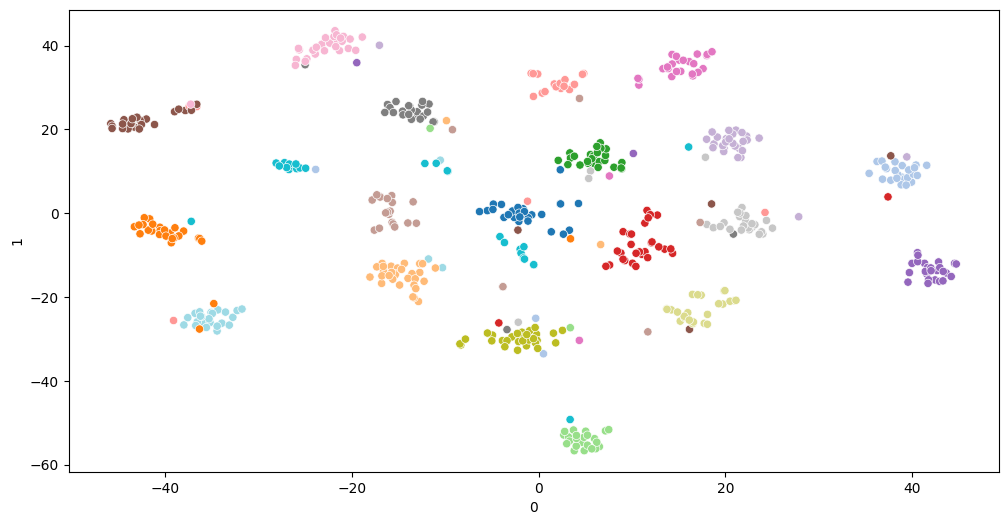

In [ ]:
from sklearn.manifold import TSNE

# Condense embeddings per node into a list
ge_em_df = pd.DataFrame({"vector": [v for v in ge_em_np]})
# Add player names (node IDs, not present in the embedding matrix)
ge_em_df["name"] = list(g_italy.networkx.nodes)
# Add club (node property)
ge_em_df = ge_em_df.merge(df_nodes[["name", "club"]], on="name")

# Apply TSNE
ge_tsne = TSNE(perplexity=12.0, metric='euclidean', random_state=1)
ge_tsne_np = ge_tsne.fit_transform(np.stack(ge_em_df["vector"].values))

# Visualize results
ge_tsne_pd = pd.DataFrame(ge_tsne_np)
ge_tsne_pd["club"] = ge_em_df["club"].values

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="club",
                     palette="tab20",
                     data=ge_tsne_pd)
ax.legend_.remove()
plt.show()

# Node2Vec with Spark <a name="node2vec"></a>

`SparkNode2Vec` in `mercury.graph.embeddings` also creates an embedding mapping the nodes of a graph using the scalable **Node2Vec** algorithm (see paper [here](https://www.semanticscholar.org/paper/node2vec%3A-Scalable-Feature-Learning-for-Networks-Grover-Leskovec/36ee2c8bd605afd48035d15fdc6b8c8842363376)). This class follows a similar approach to and has an API consistent with the `GraphEmbedding` class, but with some differences:
  - It uses **Spark** end-to-end (and graphframes as the starting point) rather than an in-memory compiled implementation. This is very useful when using large graph datasets that don't fit in memory.
  - You can load/save the embedding as parquet rather than local pickle files.
  - The embedding algorithm uses the skip-gram model and hierarchical softmax method to train the model rather than rotation in hyperspace.
  - Similarity metrics return differently. (See `.get_most_similar_nodes()` for details.)
  - The embedding is not randomly initialized and exists from scratch. You have to perform random walks to get an embedding or load it from a file.

In [ ]:
from mercury.graph.embeddings import SparkNode2Vec

In [ ]:
n2v = SparkNode2Vec(dimension=100,
                    num_paths_per_node=4,
                    num_epochs=10,
                    w2v_max_iter=10,
                    w2v_min_count=1)

print(n2v)

Object of class SparkNode2Vec.

Initialization parameters: batch_size=1000000, dimension=100, load_file=None, n_partitions_cache=10, num_epochs=10, num_paths_per_node=4, path_cache=None, sampling_ratio=1.0, use_cached_rw=False, w2v_max_iter=10, w2v_min_count=1, w2v_num_partitions=1, w2v_step_size=0.025


As in `GraphEmbedding`, the graph structure is learnt by performing random walks. However, the number of random jumps is not the given total number. Here, **all nodes** (or a sample of them) start paths up to a maximum number of steps (whenever possible). The process can be forced to restart periodically, which can be effective in addressing the issue of the random walker getting stuck in dead-end nodes, by allowing it to explore other areas of the graph more evenly.

In [ ]:
n2v.fit(g_italy)

SparkNode2Vec(batch_size=1000000, dimension=100, load_file=None, n_partitions_cache=10, num_epochs=10, num_paths_per_node=4, path_cache=None, sampling_ratio=1.0, use_cached_rw=False, w2v_max_iter=10, w2v_min_count=1, w2v_num_partitions=1, w2v_step_size=0.025)

The nodes covered in each random walk can also be inspected.

In [ ]:
print(f"Number of random walks: {n2v.paths_.count()}\n")
n2v.paths_.show(5, truncate=False)

Number of random walks: 2012

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|random_walks                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Aaron Mattia Tabacchi, Antonio Mirante, Federico Di Francesco, Mattia Destro, Federico Di Francesco, Marios Oikonomou, Juan Valencia, Erick Pulgar, Da Costa]                       |
|[Abdoulay Konko, Andrea Petagna, Boukary Drame, Leonardo Spinazzola, Remo Freuler, Salvatore Molina, Ervin Zukanovic, Bryan Cristante, Remo Freuler, Salvatore Molina, Etrit Berisha]|
|[Abdullahi Nura, Leandro Paredes, Alessandro Flor

The embedding can be retrieved completely as a Spark DataFrame, saved, reloaded or queried for similarity.

In [ ]:
n2v.embedding().show(5, truncate=False)

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

As with `GraphEmbedding`, method `get_most_similar_nodes` returns a list of nearest neighbors for a given node using cosine similarity.

In [ ]:
similarity_df_n2v = n2v.get_most_similar_nodes("Gianluigi Buffon", 5).toPandas()
similarity_df_n2v

,word,similarity
0,Rolando Mandragora,0.903911
1,Paulo Dybala,0.884605
2,Kwadwo Asamoah,0.856321
3,Federico Mattiello,0.828893
4,Stephan Lichtsteiner,0.823583


Again, many players similar to Gianluigi Buffon are also Juventus players, given how the weights and edges have been computed in the dataset.

In [ ]:
df_nodes[df_nodes["name"].isin(similarity_df_n2v["word"].tolist())]

,name,club,position
42,Paulo Dybala,Juventus,CAM
179,Stephan Lichtsteiner,Juventus,RB
442,Kwadwo Asamoah,Juventus,Sub
4642,Federico Mattiello,Juventus,Res
5494,Rolando Mandragora,Juventus,Res


The embeddings can be visualized to verify that **players in the same club are usually close by in the embedding space** by first reducing the embedding dimension to 2 using [**TSNE**](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html). Each color in the plot represents a club, and the clusters are generally distinguishable.

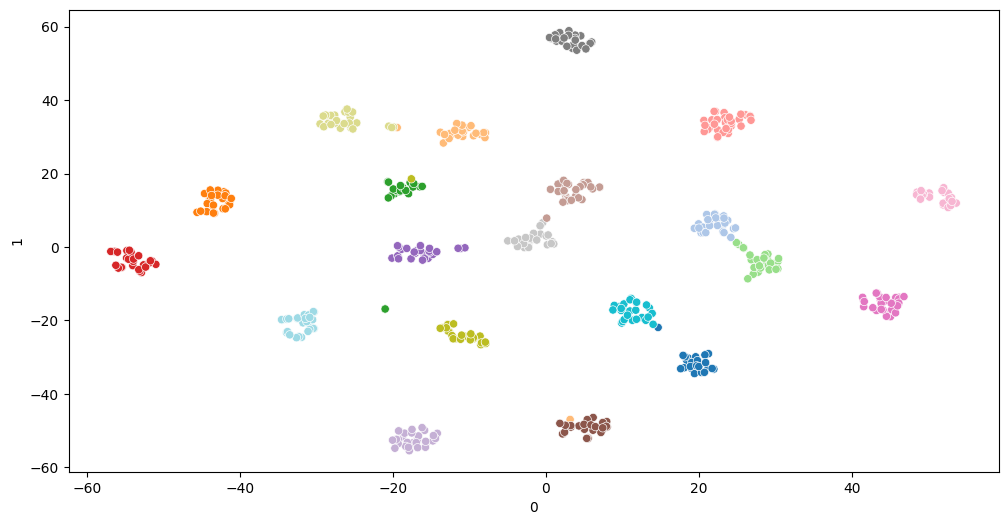

In [ ]:
from sklearn.manifold import TSNE

# Get embedding matrix as pandas dataframe
n2v_em_df = n2v.embedding().toPandas().rename(columns={"word": "name"})
# Add club (node property)
n2v_em_df = n2v_em_df.merge(df_nodes[["name", "club"]], on="name")

# Apply TSNE
n2v_tsne = TSNE(perplexity=12.0, metric='euclidean', random_state=1)
n2v_tsne_np = n2v_tsne.fit_transform(np.stack(n2v_em_df["vector"].values))

# Visualize results
n2v_tsne_pd = pd.DataFrame(n2v_tsne_np)
n2v_tsne_pd["club"] = n2v_em_df["club"].values
n2v_tsne_pd["id"] = n2v_em_df["name"].values

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="club",
                     palette="tab20",
                     data=n2v_tsne_pd)
ax.legend_.remove()
plt.show()

Finally, the embedding can be saved using `n2v.save("path/file")`. Saving the embedding to a file allows retrieving it via: `n2v = SparkNode2Vec(load_file = 'path/file')`

# Louvain community detection with Spark <a name="louvain"></a>

Class `LouvainCommunities` from `mercury.graph.ml` can be used to find the **best partition of a graph** through the **Louvain algorithm for community detection** (see paper [here](https://doi.org/10.1088/1742-5468/2008/10/p10008)), implemented using PySpark.

In [ ]:
from mercury.graph.ml import LouvainCommunities

import random

from pyvis.network import Network
from IPython.display import HTML

In [ ]:
lc = LouvainCommunities()

print(lc)

Object of class LouvainCommunities.

Initialization parameters: all_partitions=True, max_iter=10, max_pass=2, min_modularity_gain=0.001, resolution=1, verbose=True


We can first execute the algorithm on the small subgraph that contains AS Roma's starting players.

In [ ]:
lc.fit(g_roma_11)

Starting Pass 0 Iteration 0.
Starting Pass 0 Iteration 1.
Starting Pass 0 Iteration 2.
Starting Pass 1 Iteration 0.
Starting Pass 1 Iteration 1.
Starting Pass 1 Iteration 2.
Starting Pass 1 Iteration 3.
Starting Pass 2 Iteration 0.


LouvainCommunities(all_partitions=True, max_iter=10, max_pass=2, min_modularity_gain=0.001, resolution=1, verbose=True)

Accessing `.labels_` after fitting shows a DataFrame with the optimal partitions found at the end of each pass.


In [ ]:
lc.labels_.show(truncate=False)

+----------------+-----+-----+-----+
|id              |pass0|pass1|pass2|
+----------------+-----+-----+-----+
|Antonio Rudiger |1    |5    |5    |
|Emerson         |5    |5    |5    |
|Daniele De Rossi|3    |6    |5    |
|Federico Fazio  |6    |6    |5    |
|Mohamed Salah   |9    |6    |5    |
|Bruno Peres     |2    |8    |10   |
|Kostas Manolas  |8    |8    |10   |
|Edin Deko       |4    |10   |10   |
|Radja Nainggolan|10   |10   |10   |
|Kevin Strootman |7    |11   |6    |
|Wojciech Szczsny|11   |11   |6    |
+----------------+-----+-----+-----+



In this case, the algorithm is able to find the globally optimal partition in three passes.

In [ ]:
communities_roma = lc.labels_.toPandas().set_index("id").loc[list(g_roma_11.networkx.nodes())].reset_index()
communities_roma.groupby("pass2").agg({"id": lambda x: set(x)})

,id
pass2,
5,"{Mohamed Salah, Antonio Rudiger, Emerson, Daniele De Rossi, Federico Fazio}"
6,"{Kevin Strootman, Wojciech Szczsny}"
10,"{Edin Deko, Radja Nainggolan, Bruno Peres, Kostas Manolas}"


The assignment of each node/player to a partition can also be visualized for better interpretation.

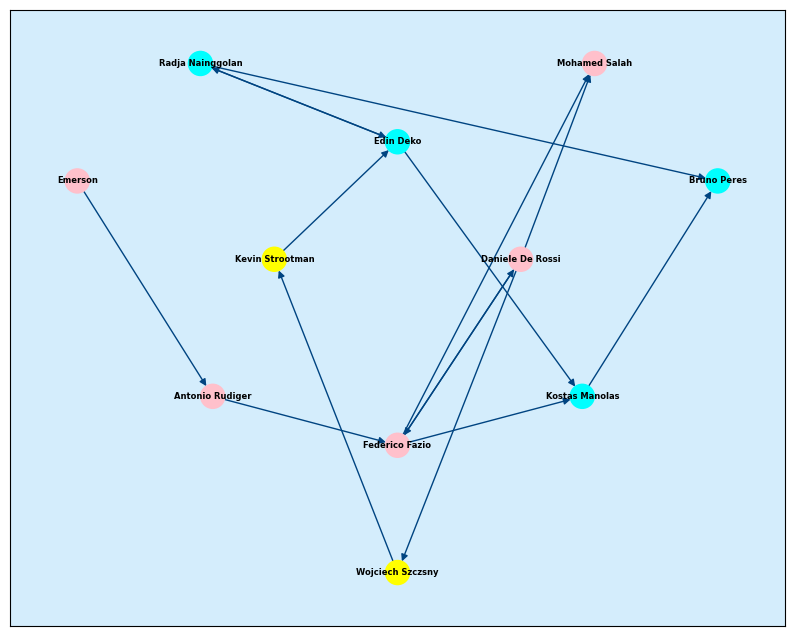

In [ ]:
color_map = {
    5: "pink",
    6: "yellow",
    10: "cyan",
}
node_colors = [color_map[comm_id] for comm_id in communities_roma["pass2"]]

plot_football_field(g_roma_11, player_positions=player_positions_roma, node_colors=node_colors)

We can also test the algorithm on a bigger subgraph, with all of the players of Italian clubs (as was defined in previous steps). Again, the optimal partition is found in three passes.

In [ ]:
lc_italy = LouvainCommunities()

lc_italy.fit(g_italy)

Starting Pass 0 Iteration 0.
Starting Pass 0 Iteration 1.
Starting Pass 0 Iteration 2.
Starting Pass 0 Iteration 3.
Starting Pass 0 Iteration 4.
Starting Pass 0 Iteration 5.
Starting Pass 0 Iteration 6.
Starting Pass 0 Iteration 7.
Starting Pass 0 Iteration 8.
Starting Pass 0 Iteration 9.
Starting Pass 1 Iteration 0.
Starting Pass 1 Iteration 1.
Starting Pass 1 Iteration 2.
Starting Pass 1 Iteration 3.
Starting Pass 1 Iteration 4.
Starting Pass 1 Iteration 5.
Starting Pass 1 Iteration 6.
Starting Pass 1 Iteration 7.
Starting Pass 2 Iteration 0.
Starting Pass 2 Iteration 1.


LouvainCommunities(all_partitions=True, max_iter=10, max_pass=2, min_modularity_gain=0.001, resolution=1, verbose=True)

The number of communities found is very similar to the number of clubs in the Italian league. This is to be expected, given that the weight of the relationships between players in the original graph is higher if the players belong to the same club.

In [ ]:
comm_ids_italy = lc_italy.labels_.select("pass2").distinct()

num_comms_italy = comm_ids_italy.count()

print(f"Number of communities detected: {num_comms_italy}")
print(f"Number of Italian clubs: {len(italy_clubs)}")

Number of communities detected: 21
Number of Italian clubs: 20


The results can be better understood visually. Given the size and complexity of the graph, an interactive plot that allows labels to only be shown when zooming in is a more suitable option, so we will use the `pyvis` package. Additionally, this package generates a visualization that groups nodes through a physics simulation based on an inverted gravity model, meaning that communities detected by the Louvain algorithm will be seen more clearly.

In [ ]:
lc_italy_df = lc_italy.labels_.toPandas()

# Assign distinct colors to each community
comm_colors_italy = ["#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)]) for i in range(num_comms_italy)]
comm_to_color_italy = dict(zip(comm_ids_italy.toPandas()["pass2"].to_list(), comm_colors_italy))

lc_italy_df["color"] = lc_italy_df["pass2"].map(comm_to_color_italy)

*Note: The following graph visualization may take a few seconds to render.*

In [ ]:
nt = Network(notebook=True, cdn_resources='remote', directed=True)

# Add nodes
for _, row in lc_italy_df.iterrows():
  nt.add_node(row["id"], color=row["color"])

# Add edges
for edge in g_italy.edges:
  nt.add_edge(edge["src"], edge["dst"])

# Set options and save visualization
nt.set_options("""
var options = {
  "interaction": {
    "hover": true
  }
}
""")
nt.save_graph("louvain.html")

# View results
HTML(filename="louvain.html")

Another option for visualizing the detected communities is by coloring the embedding space created by [SparkNode2Vec](#node2vec) and reduced to two dimensions by using [TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html). This approach allows us to verify that the partitions detected make sense, although it does not show information on the edges or the structure of the graph.

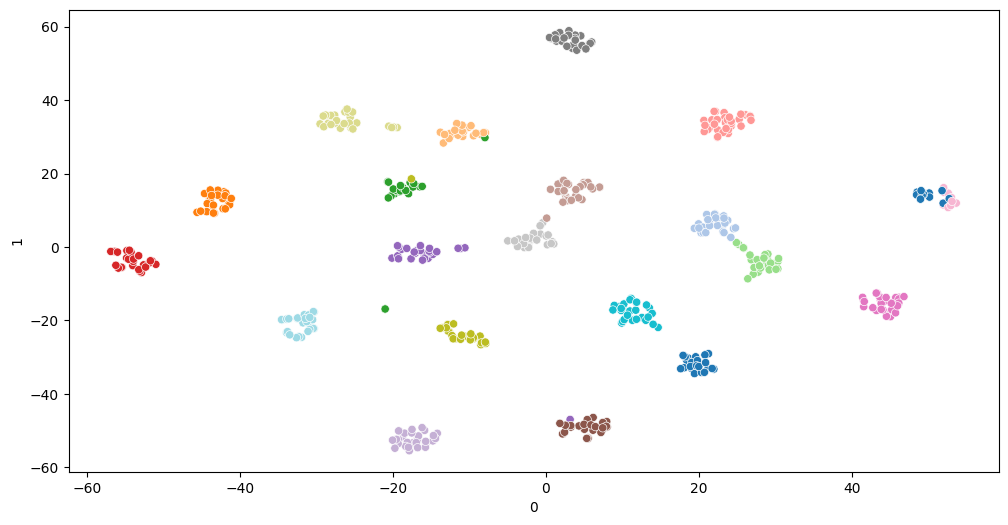

In [ ]:
lc_italy_n2v_tsne_df = n2v_tsne_pd.merge(lc_italy_df[["id", "pass2"]], on="id")
lc_italy_n2v_tsne_df["pass2"] = lc_italy_n2v_tsne_df["pass2"].astype(str)

fig, axes = plt.subplots(1, 1, figsize=((12,6)))
ax = sns.scatterplot(x=0, y=1,
                     hue="pass2",
                     palette="tab20",
                     data=lc_italy_n2v_tsne_df)
ax.legend_.remove()
plt.show()

# Spectral clustering <a name="spectral"></a>

Class `SpectralClustering` from `mercury.graph.ml` implements the **unsupervised [spectral clustering algorithm](https://www.sciencedirect.com/topics/computer-science/spectral-clustering)** to group nodes in a graph. This algorithm can work in two modes: "networkx" (running the algorithm locally, with a methodology similar to [scikit-learn's implementation](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.SpectralClustering.html) but expecting a graph object instead of a numpy array) or "spark" (using PySpark and graphframes).

In [ ]:
from mercury.graph.ml import SpectralClustering

In [ ]:
sc = SpectralClustering(n_clusters=3, mode="networkx")

print(sc)

Object of class SpectralClustering.

Initialization parameters: max_iterations=10, mode=networkx, n_clusters=3, random_state=0


As with `LouvainCommunities`, cluster assignments are available after fitting through the pandas dataframe `.labels_`, following the `scikit-learn` convention:

In [ ]:
sc.fit(g_roma_11)

SpectralClustering(max_iterations=10, mode=networkx, n_clusters=3, random_state=0)

In [ ]:
sc.labels_

,node_id,cluster
0,Mohamed Salah,0
1,Radja Nainggolan,2
2,Kevin Strootman,0
3,Antonio Rudiger,1
4,Daniele De Rossi,0
5,Bruno Peres,2
6,Wojciech Szczsny,0
7,Emerson,1
8,Edin Deko,2
9,Federico Fazio,1


In [ ]:
sc.labels_.groupby("cluster").agg({"node_id": lambda x: set(x)})

,node_id
cluster,
0,"{Kevin Strootman, Mohamed Salah, Wojciech Szczsny, Daniele De Rossi}"
1,"{Antonio Rudiger, Federico Fazio, Emerson}"
2,"{Edin Deko, Bruno Peres, Radja Nainggolan, Kostas Manolas}"


Again, the assignment of each node/player to a cluster can also be visualized for better interpretation. When setting the number of clusters to `k=3`, slightly different clusters are obtained compared to the partitions from `LouvainCommunities`, but the results are similar nonetheless.

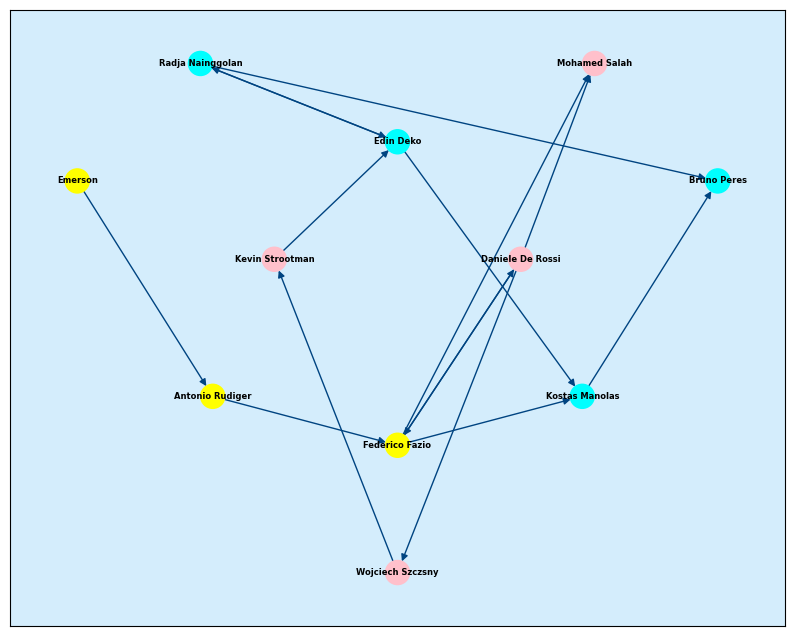

In [ ]:
color_map = {
    0: "pink",
    1: "yellow",
    2: "cyan",
}
node_colors = [color_map[comm_id] for comm_id in sc.labels_["cluster"]]

plot_football_field(g_roma_11, player_positions=player_positions_roma, node_colors=node_colors)

**Modularity** is a metric that measures the strength of the division of a graph into clusters. The evolution of modularity for each number of clusters (`k`) can be observed, showing that a number of clusters between 2 and 4 should be used for best results.

In [ ]:
print(f"Modularity: {sc.modularity_}")

Modularity: 0.3520710059171598


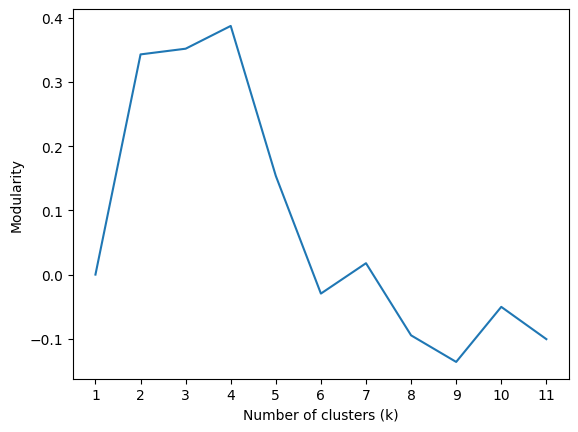

In [ ]:
modularities = []
num_clusters = range(1, 12)

for k in num_clusters:
  sc = SpectralClustering(n_clusters=k, mode="networkx")
  sc.fit(g_roma_11)
  modularities.append(sc.modularity_)

sns.lineplot(x=num_clusters, y=modularities)
plt.xlabel("Number of clusters (k)")
plt.xticks(ticks=num_clusters)
plt.ylabel("Modularity")
plt.show()

Spectral clustering can also be performed using PySpark under the hood by simply passing `mode="spark"` to the constructor, which uses the `Graph` object's graphframe property.

# Transition matrix (Markov chains) <a name="transition"></a>

Class `Transition` of `mercury.graph.ml` can be used to obtain the **transition matrix** of a graph, which computes the distribution of probability of being in each of the nodes (or states) of a directed graph (or Markov process).

In [ ]:
from mercury.graph.ml import Transition

In [ ]:
tm = Transition().fit(g_roma_11).to_pandas()

tm

,Edin Deko,Kostas Manolas,Bruno Peres,Emerson,Daniele De Rossi,Wojciech Szczsny,Antonio Rudiger,Federico Fazio,Kevin Strootman,Radja Nainggolan,Mohamed Salah
Edin Deko,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.5,0.000000
Kostas Manolas,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Bruno Peres,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Emerson,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000
Daniele De Rossi,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.333333,0.0,0.0,0.333333
Wojciech Szczsny,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.000000
Antonio Rudiger,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000
Federico Fazio,0.0,0.333333,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.333333
Kevin Strootman,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Radja Nainggolan,0.5,0.000000,0.5,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


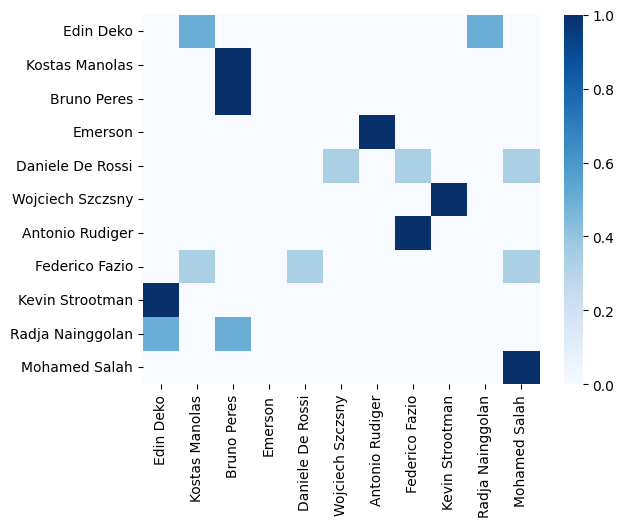

In [ ]:
sns.heatmap(tm, cmap="Blues")
plt.show()

# Spread activation with Spark <a name="spread-activation"></a>

Class `SparkSpreadingActivation` of mercury.graph.ml is a model that represents a **“word-of-mouth” scenario where a node influences its neighbors**, from where the influence spreads to other neighbors, and so on. At the end of the diffusion process (`fit()`), implemented in Spark, the amount of influence received by each node can be inspected through the DataFrame stored in `.influences_`. Using a threshold-based technique, a node that is currently not influenced can be declared to be a potential future one, based on the influence that has been accumulated.

The diffusion model is based on Spreading Activation (SPA) techniques proposed in cognitive psychology and later used for trust metric computations (see paper ["Social Ties and their Relevance to Churn in Mobile Telecom Networks"](https://pdfs.semanticscholar.org/3275/3d80adb5ec2d4a974b5d1a872e2c957b263b.pdf)).

In [ ]:
from mercury.graph.ml import SparkSpreadingActivation

In [ ]:
sa = SparkSpreadingActivation(spreading_factor=0.5, steps=3, transfer_function="weighted")

print(sa)

Object of class SparkSpreadingActivation.

Initialization parameters: attribute=influence, influenced_by=False, spreading_factor=0.5, steps=3, transfer_function=weighted


One or more **seed nodes** must be set as the origin of the diffusion process.

In [ ]:
seed_nodes = ["Gianluigi Buffon"]
sa.fit(g_italy, seed_nodes=seed_nodes)

SparkSpreadingActivation(attribute=influence, influenced_by=False, spreading_factor=0.5, steps=3, transfer_function=weighted)

As mentioned, the **amount of influence received by each node** (the total influence adds up to 1, if there is one seed node) can be inspected through `.influences_`.

In [ ]:
sa.influences_.orderBy(f.col("influence").desc()).show()

+--------------------+--------------------+
|                  id|           influence|
+--------------------+--------------------+
|  Rolando Mandragora|               0.375|
|    Gianluigi Buffon|               0.125|
|     Stefano Sturaro| 0.10416666666666667|
|  Federico Mattiello|             0.09375|
|                Neto|             0.09375|
|        Paulo Dybala|             0.09375|
|     Andrea Barzagli|             0.03125|
|      Kwadwo Asamoah|             0.03125|
|         Marko Pjaca|             0.03125|
|      Miralem Pjanic|0.010416666666666666|
|        Sami Khedira|0.010416666666666666|
|Aaron Mattia Taba...|                 0.0|
|      Abdoulay Konko|                 0.0|
|      Abdullahi Nura|                 0.0|
|         Adam Masina|                 0.0|
|           Adam Nagy|                 0.0|
|        Adel Taarabt|                 0.0|
|         Adem Ljajic|                 0.0|
|       Adrian Stoian|                 0.0|
|      Afriyie Acquah|          

In [ ]:
sa.influences_.select(f.sum("influence")).show()

+--------------+
|sum(influence)|
+--------------+
|           1.0|
+--------------+



The interaction between the nodes that spread and receive influence can also be plotted and inspected visually:

In [ ]:
influenced_customers_df = sa.influences_.filter(f.col("influence")>0).toPandas()
g_influenced_customers = g_italy.networkx.subgraph(influenced_customers_df["id"].tolist())
g_influenced_customers

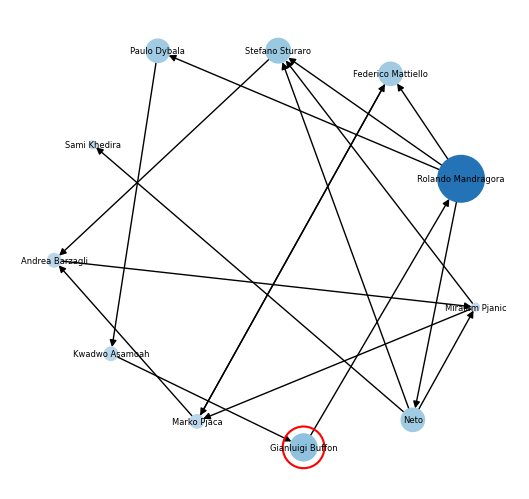

In [ ]:
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=influenced_customers_df["influence"].min()-0.2,
                     vmax=influenced_customers_df["influence"].max()+0.2)
node_colors = [cmap(norm(influenced_customers_df.loc[influenced_customers_df["id"] == node_id, "influence"]))
               for node_id in list(g_influenced_customers.nodes)]

pos = nx.spring_layout(g_influenced_customers, k=10)
nx.draw(g_influenced_customers, pos, node_color=node_colors, with_labels=True, font_size=6,
        node_size=[influenced_customers_df.loc[influenced_customers_df["id"] == node_id, "influence"].iloc[0]*3000 for node_id in list(g_influenced_customers.nodes)])

ax = plt.gca()
for node in seed_nodes:
  circle = plt.Circle(pos[node], radius=0.098, color="red", fill=False, lw=1.5, transform=ax.transData)
  ax.add_patch(circle)

ax.set_aspect("equal")
plt.show()